<a href="https://colab.research.google.com/github/PabloPoche/api_service_python/blob/master/1_segmentacion_paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# Segmentación de países

Crear un modelo de segmentación para la clasificación de paises por categoría (desarrollado, en desarrollo, subdesarollado) según sus datos a nivel macro<br>
v1.1

In [1]:
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Recolectar datos
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline1.png" width="1000" align="middle"></div>

In [2]:
if os.access('Country-data.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Country-data.csv > Country-data.csv
    else:
        !wget Country-data.csv https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Country-data.csv

--2023-03-17 01:56:24--  http://country-data.csv/
Resolving country-data.csv (country-data.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘country-data.csv’
--2023-03-17 01:56:24--  https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Country-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9229 (9.0K) [text/plain]
Saving to: ‘Country-data.csv’

Country-data.csv    100%[===================>]   9.01K  --.-KB/s    in 0s      

2023-03-17 01:56:24 (52.3 MB/s) - ‘Country-data.csv’ saved [9229/9229]

FINISHED --2023-03-17 01:56:24--
Total wall clock time: 0.3s
Downloaded: 1 files, 9.0K in 0s (52.3 MB/s)


### `Country-data.csv`:
El dataset **`Country-data.csv`** contiene datos a nivel macroeconomía, ingresos y poblacional sobre países del mundo para su segmentación.<br>
[Dataset source](Country-data.csvn)
- **country** --> nombre del país
- **child_mort** --> cuantos niños menores a 5 años mueren de cada 1000
- **exports** --> exportación de bienes y servicios per cápita
- **health** --> inversiones en salud per cápita
- **import** --> importación de bienes y servicios per cápita
- **Income** --> ingresos por persona (neto)
- **Inflation** --> inflación anual
- **life_expec** --> Promedio de expectativa de vida
- **total_fer** --> Cuantos niños por pareja hay en promedio
- **gdpp** --> Producto bruto interno per cápita

In [3]:
df = pd.read_csv("Country-data.csv")

# Procesar datos
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline2.png" width="1000" align="middle"></div>

In [4]:
# Alumno, inspeccione el dataset, visualice las columnas que posee y sus primeras filas
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# Alumno, realice una inspeccion del dataset en búsqueda de elementos faltantes
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
# Alumno: ¿Cuántas filas/datos hay para analizar?
print('Hay', df.shape[0], 'filas para analizar.')

Hay 167 filas para analizar.


# Explorar datos
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline3.png" width="1000" align="middle"></div>

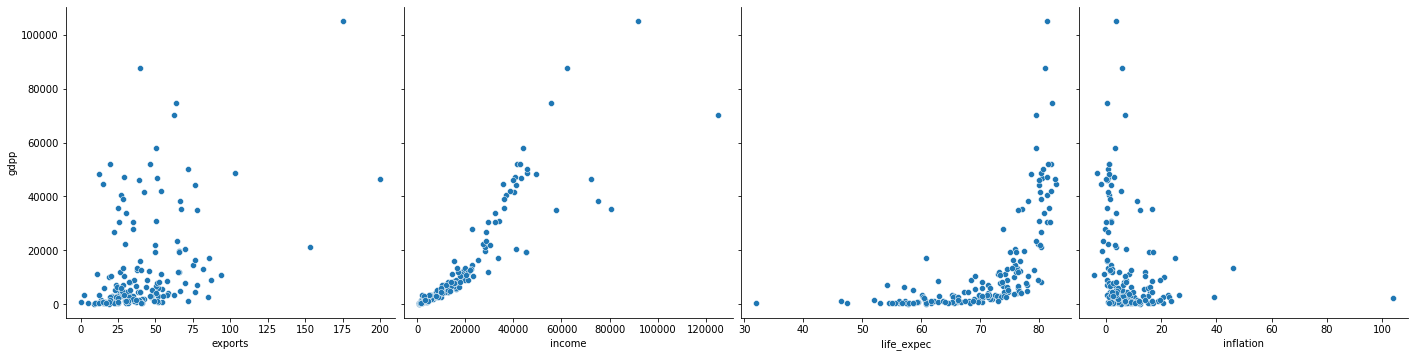

In [27]:
# Observar todas las relaciones entre el feature del producto bruto interno
# y los siguientes features
# Utilizar pairplot con y_vars=['gdpp']
# Utilizar pairplot con x_vars=['exports', 'income', 'life_expec', 'inflation']
# Recordar desactivar la diagonal(diag_kind=None,)
sns.pairplot(data=df, x_vars=['exports', 'income', 'life_expec', 'inflation'], y_vars=['gdpp'], diag_kind=None, height=5)
plt.show()

Deberían observar que a medida que aumenta el producto bruto interno aumenta la exportación, el ingreso por persona (incoma), la expectativa de vida (life_expec) y baja la inflación (inflation). Este parámetro lo debe utilizar luego para determinar si los paises segmentados son:
- desarrollados
- en_desarrollo
- subdesarrollados

# Entrenar modelo
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline4.png" width="1000" align="middle"></div>

In [8]:
# Almuno: Crear un numpy array "X" con los features de entrada expecto el nombre del pais (country)
X = df.drop('country', axis=1).values

#### Crear un modelo de segmentación con Kmeans
Parámetros
- n_clusters --> (k) número de clusters/grupos (defecto 5)
- init --> método utilizado para determianr donde comienzan los clusters
 - k-means++ --> mecanismo inteligente para determinar el comienzo (defecto)
 - random --> los centros se determinarn aleatoriamente
- max_iter --> cantidad de iteración (defecto 300)

In [9]:
# Almuno: Entrenar un modelo de Kmeans en un rango de cluster (2, 10)
# Conservar el resultado de "inertial" para utilizar como métrica de selccion
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_best_model(X, max_clusters=10):
    n_clusters = list(range(2, max_clusters+1))
    ensayos = len(n_clusters)                   
    array_error = np.zeros((ensayos)) 
    array_score = np.zeros((ensayos)) 

    for i in range(ensayos):
        kmeans = KMeans(n_clusters=n_clusters[i], init="k-means++", random_state=0)
        kmeans.fit(X)
        array_error[i] = kmeans.inertia_
        array_score[i] = silhouette_score(X, kmeans.labels_)

    return array_error, array_score, n_clusters

In [10]:
array_error, array_score, n_clusters = find_best_model(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [11]:
# Dibujar la evolucion del error (inertia) y deteminar el 
# punto de quiebre (elbow point)
def graficar_punto_codo(array_error, array_score, n_clusters):
  fig = plt.figure()
  ax = fig.add_subplot()
  ax.plot(n_clusters, array_error/array_error.max(), label='error') 
  ax.plot(n_clusters, array_score, label='score')
  ax.grid('dashed')
  ax.legend()
  plt.show()


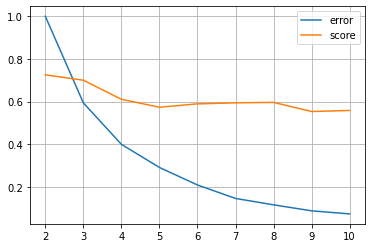

In [13]:
graficar_punto_codo(array_error, array_score, n_clusters)



Se puede observar que el punto de elbow podría ser con cluster=4, pero ya sabemos de ante mano que queremos dividir el dataset en 3 grupos, utilizaremos n_clusters=3

In [14]:
# Alumno: Entrenar el modelo con el mejor n_clusters=3
# y determinar los labels
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=0)
kmeans.fit(X)
labels = kmeans.predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
# Alumno: Sumar la columna de labels con el nombre de countryseg (customer segmentation)
# a su dataset
df['countryseg'] = labels
df


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,countryseg
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1


# Validar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline5.png" width="1000" align="middle">

In [18]:
# Alumno: Calcular la exactitud (accuracy) del modelo
from sklearn.metrics import silhouette_score
silhouette_score (X, kmeans.labels_)

0.7003508054481694

# Utilizar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline6.png" width="1000" align="middle">

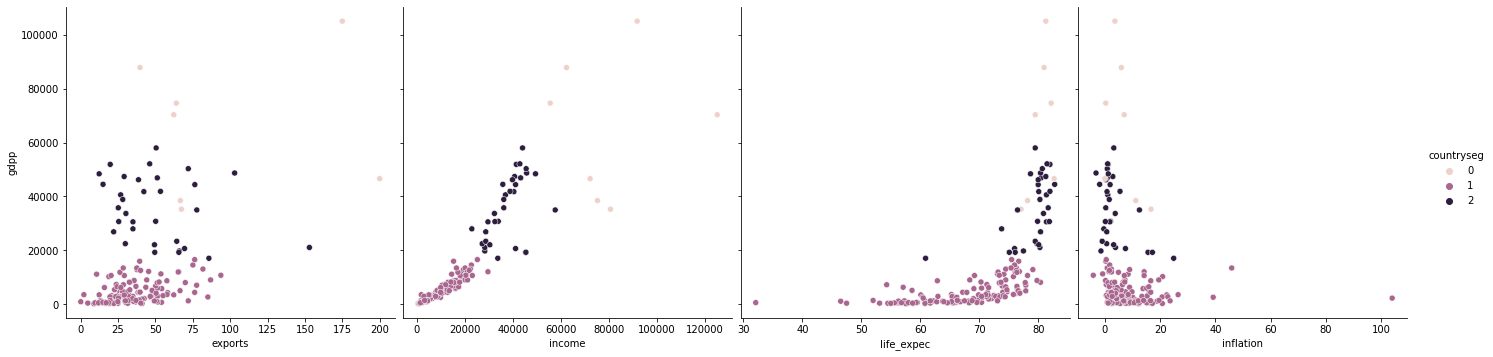

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,countryseg
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1


In [30]:
# Alumno: Volver a repetir el gráfico de pairplot que realizó antes
# con ['exports', 'income', 'life_expec', 'inflation']
# pero ahora utilizando para hue la columna countryseg
sns.pairplot(data=df, x_vars=['exports', 'income', 'life_expec', 'inflation'], y_vars=['gdpp'], diag_kind=None, height=5, hue='countryseg')
plt.show()
df


In [38]:
# Alumno: viendo los gráficos, principalmente el de ingresos (income), deteminar
# la categoría de cada cluster y colocarla en una columna countrycat.
# Utilizar lambda expresion en función de country_seg para crear
# esa nueva coulmna
# - desarrollado
# - desarrollandose
# - subdesarrollado

df['countrycat'] = df['countryseg'].apply(lambda x : 'desarrollado' if x == 0 else 'desarrollandose' if x == 2 else 'subdesarrollado')


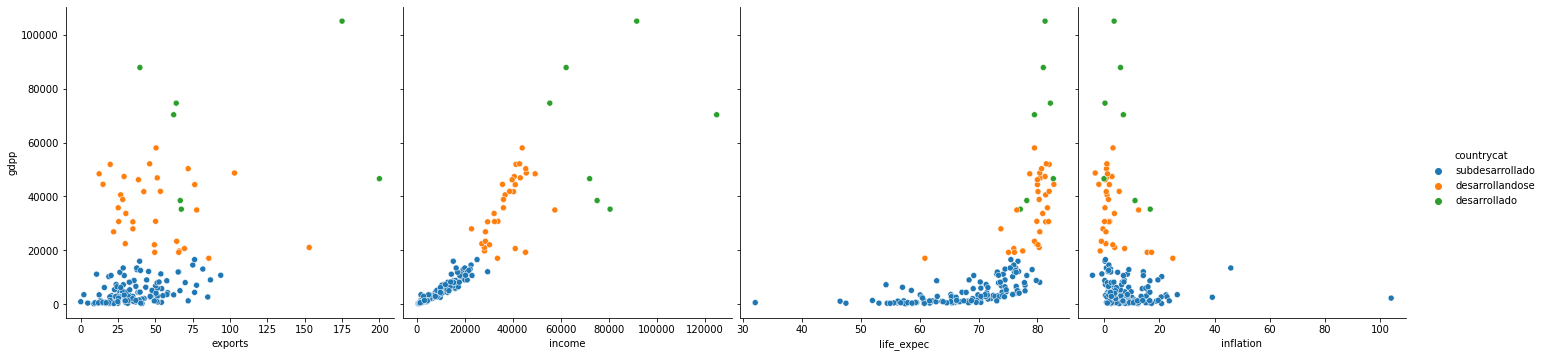

In [39]:
# Alumno: volver a graficar el gráfico anterior pero ahora usando en 
# en hue = 'countrycat'
sns.pairplot(data=df, x_vars=['exports', 'income', 'life_expec', 'inflation'], y_vars=['gdpp'], diag_kind=None, height=5, hue='countrycat')
plt.show()

Hay 7 paises desarrollados
Hay 32 paises desarrollandose
Hay 128 paises subdesarrollados


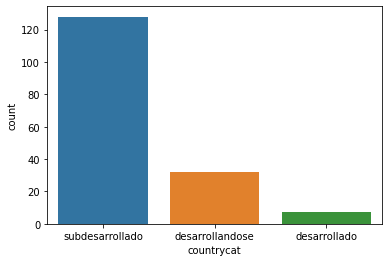

In [46]:
# Alumno: Determinar cuantas países hay en cada categoría
# utilizando el gráfico de seaborn countplot en la columna countrycat
print("Hay", df['countrycat'].value_counts()[2],"paises desarrollados")
print("Hay", df['countrycat'].value_counts()[1],"paises desarrollandose")
print("Hay", df['countrycat'].value_counts()[0],"paises subdesarrollados")

sns.countplot(x='countrycat', data=df)
plt.show()

Bueno ahora a jugar! Ahora puede buscar en su dataset algún país en general y ver su categoría según el modelo que armó

# Conclusión
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline7.png" width="1000" align="middle">